# Table of Contents <a id='top'></a> 
                                                          

1. [Import Packages](#imports)<br>
2. [Define Functions](#functions)<br> 
3. [Conduct Experiments](#experiments)<br> 
4. [Visualize Results](#visualize)<br> 

---
## 1: Import Packages <a id='imports'></a> 
[jump to top](#top)<br>

In [20]:
# modules I created
from bidder import Bidder
from auction import Auction, User

# outside libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

--- 
## 2: Define Functions <a id='functions'></a> 
[jump to top](#top)<br>

In [2]:
def run_experiment(auction):
    for i in range(auction.bidders[0].num_rounds):
        auction.execute_round()

In [3]:
def overview(auction, game_state_id = None):
    """Given a completed auction (an auction object for which .execute() has been repeatedly called),
    summarize the attributes of the bidders involved and indicate the final balance of each bidder"""
    
    dicty = {"auction_id": [],
             "bidder_id": [],
             "bidder_type": [],
             "alpha": [],
             "aggressiveness": [],
             "under_cut": [],
             "num_users": [],
             "final_balance": []}

    for bidder in auction.bidders:
        dicty["auction_id"].append(auction.auction_id)
        dicty["bidder_id"].append(bidder.bidder_id)
        dicty["bidder_type"].append(bidder.bidder_type)
        if bidder.bidder_type == "smart":
            dicty["alpha"].append(bidder.alpha)
            dicty["aggressiveness"].append(bidder.aggressiveness)
            dicty["under_cut"].append(bidder.under_cut)
        else:
            dicty["alpha"].append("NA")
            dicty["aggressiveness"].append("NA")
            dicty["under_cut"].append("NA")
        dicty["num_users"].append(len(auction.users))
        dicty["final_balance"].append(auction.balances[bidder])

    summary_df = pd.DataFrame(dicty)
    
    if game_state_id != None:
        summary_df["game_state_id"] = [game_state_id for i in range(len(summary_df))]
        return summary_df[["auction_id"] + ["game_state_id"] + ["bidder_id", "bidder_type", "alpha", "aggressiveness", "under_cut", "num_users", "final_balance"]]
    else:
        return summary_df


--- 
## 3: Conduct Experiments <a id='experiments'></a> 
[jump to top](#top)<br>

In [4]:
alpha_levels = [i/10 for i in range(10)]
aggressiveness_levels = [i/20 for i in range(20)]
under_cut_levels = [i/20 for i in range(0, 5)]

In [11]:
dict_bidders = {"bidder_id":[], "alpha": [], "aggressiveness": [], "under_cut": []}

i = 0
for alpha in alpha_levels:
    for agg in aggressiveness_levels:
        for undercut in under_cut_levels:
            dict_bidders["bidder_id"].append(i)
            dict_bidders["alpha"].append(alpha)
            dict_bidders["aggressiveness"].append(agg)
            dict_bidders["under_cut"].append(undercut)
            i += 1
            
df_bidders = pd.DataFrame(dict_bidders)  
df_bidders["num_auctions_played"] = [0 for i in range(len(df_bidders))]
df_bidders["total_balance"] = [0 for i in range(len(df_bidders))]
# df_bidders["average_final_balance"] = df_bidders["total_balance"] / df_bidders["num_auctions_played"]
df_bidders['average_final_balance'] = df_bidders.apply(
    lambda row: row['total_balance'] / row['num_auctions_played'] if row['num_auctions_played'] != 0 else 0,
    axis=1
)
df_bidders

,bidder_id,alpha,aggressiveness,under_cut,num_auctions_played,total_balance,average_final_balance
0,0,0.0,0.00,0.00,0,0,0
1,1,0.0,0.00,0.05,0,0,0
2,2,0.0,0.00,0.10,0,0,0
3,3,0.0,0.00,0.15,0,0,0
4,4,0.0,0.00,0.20,0,0,0
...,...,...,...,...,...,...,...
995,995,0.9,0.95,0.00,0,0,0
996,996,0.9,0.95,0.05,0,0,0
997,997,0.9,0.95,0.10,0,0,0
998,998,0.9,0.95,0.15,0,0,0


**So I want to track the performance of each of these bidders across different combinations of other bidders as well as num_users**

My idea right now is to randomly draw a random number of bidders from that data frame ^ and run an auction with them. Then I will repeat this over and over again until each bidder has been selected like 10 times (?). 

In [10]:
def run_record_auction():
    """Do it all"""
    
    # instantiate 10 users
    users = [User() for i in range(10)]
    
    # decide how many smart bidders will participate, it will be anywhere from 5 to 9
    num_bidders = np.random.randint(5, 10)

    # randomly select bidders from the table df_bidders 
    bidders_ids = np.random.choice(df_bidders.index, num_bidders)
    
    # instantiate the bidders with the attributes defined in the df_bidders table
    bidders = [Bidder(num_users=10, num_rounds=1000, bidder_type="zero")] + [Bidder(10, 1000, bidder_id = bidders_ids[i], bidder_type="smart", alpha=df_bidders.loc[bidders_ids[i]][1], aggressiveness=df_bidders.loc[bidders_ids[i]][2], under_cut=df_bidders.loc[bidders_ids[i]][3]) for i in range(num_bidders)] + [Bidder(num_users=10, num_rounds=1000, bidder_type="random")]
    
    # instantiate the auction with the users and bidders created above
    auction = Auction(users, bidders, 127)
    
    # execute 1000 rounds of the auction
    run_experiment(auction)
    
    # summarize the outcome of the auction
    overview_df = overview(auction, game_state_id=33)
    
    # record the results of the auction in the df_bidders dataframe
    smart_bidders_df = overview_df[overview_df["bidder_type"]=="smart"]
    smart_bidders_df = smart_bidders_df.reset_index()
    for i in range(len(smart_bidders_df)):
        final_balance = smart_bidders_df.loc[i, "final_balance"]
        bidder_id = smart_bidders_df.loc[i, "bidder_id"]
        df_bidders.loc[bidder_id, "total_balance"] += final_balance
        df_bidders.loc[bidder_id, "num_auctions_played"] += 1
        df_bidders.loc[bidder_id, "average_final_balance"] = df_bidders.loc[bidder_id, "total_balance"] / df_bidders.loc[bidder_id, "num_auctions_played"]

In [28]:
# run the experiment many times and time how long it takes

import time

a = time.time()

for i in range(1000):
    run_record_auction()

b = time.time()

print(round(b-a, 2), "seconds")

16.01 seconds


In [34]:
# see which bidders are doing best and worst 

df_bidders.loc[df_bidders.num_auctions_played>0].sort_values(by="average_final_balance", ascending=False)

,bidder_id,alpha,aggressiveness,under_cut,num_auctions_played,total_balance,average_final_balance
277,277,0.2,0.75,0.10,13,737.485216,56.729632
555,555,0.5,0.55,0.00,15,534.216738,35.614449
181,181,0.1,0.80,0.05,17,570.671895,33.568935
467,467,0.4,0.65,0.10,10,298.527203,29.852720
176,176,0.1,0.75,0.05,12,350.175969,29.181331
...,...,...,...,...,...,...,...
799,799,0.7,0.95,0.20,11,-1770.360290,-160.941845
995,995,0.9,0.95,0.00,15,-2477.040812,-165.136054
896,896,0.8,0.95,0.05,14,-2324.568463,-166.040605
897,897,0.8,0.95,0.10,13,-2164.192245,-166.476327


In [32]:
# this cell is just to find out the min and max of num_auctions_played in order to make a good histogram below

df_bidders[["num_auctions_played"]].describe()

,num_auctions_played
count,1000.000000
mean,14.752000
std,3.718645
min,2.000000
25%,12.000000
50%,15.000000
75%,17.000000
max,27.000000


(array([  1.,   0.,   0.,   0.,   7.,  11.,  15.,  41.,  51.,  72.,  89.,
         84., 117., 103., 105.,  82.,  53.,  59.,  42.,  30.,  17.,   8.,
          9.,   1.,   3.]),
 array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.]),
 <BarContainer object of 25 artists>)

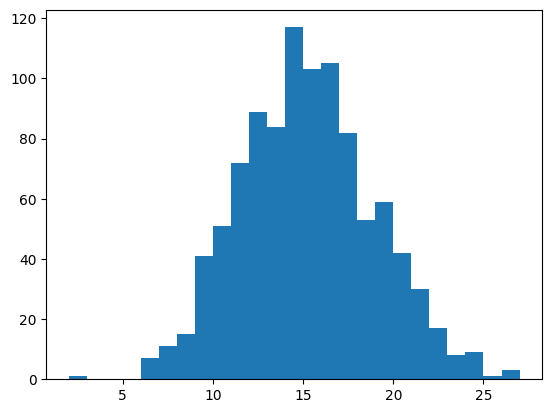

In [33]:
# look at the full distribution of num_auctions_played

plt.hist(df_bidders.num_auctions_played, bins=25)

It might take about a minute to run enough simulations that very few bidders have fewer than 10 auctions played. Getting the *minimum* to 10 might take a long time though.

--- 
## 4: Visualize Results <a id='visualize'></a> 
[jump to top](#top)<br>

**Visualization idea: scatter plot of all the bidders with alpha on one axis, aggressiveness on the other, and they are colored by their average_final_balance**